## Introduction

An artist's perception of the world is often through a different lens. Vincent van Gogh, working during the Impressionist Era, rejected the exactness of increasingly popular photography in favor of simpler representations, reducing the subjects of his paintings to their essential features. Produced with coarse, prominent brush strokes or an unconventional color palette, van Gogh's portraits were unmistakably distinguishable, though far from an exact likeness.

Principal component analysis is much like a view through an artist's eye. By reducing a collection of data only to those features which capture the greatest *variability* across the dataset, it can provide a simpler representation of high-dimensional data.

A common application of principal component analysis is dimensionality reduction, as principal components are sorted to express as much variability in the data as possible. We will use animation to illustrate how principal component analysis can be used to reconstruct an image with considerably less information needed.

As our test image dataset, we have collected color images of Vincent van Gogh's portrait artwork, cropped to a uniform $136\times136$ pixel region - an image basis of $136\times136\times3=55488$ basis vectors. All images are obtained from [vincentvangogh.org](https://www.vincentvangogh.org/), which hosts a gallery of van Gogh's works.

Principal component analysis involves a change of basis; rather than characterizing each image by a set of coordinates representing pixel RGB values, the image can be suitably represented in a new basis of principal axes, which is typically smaller than the initial number of coordinates. Each principal axis is some linear combination of the image basis vectors, formed so that the coordinate of the images along the first principal axis - their first principal component - has the largest variance. The second principal axis is chosen such that the second principal component has the next largest possible variance while maintaining that the second and first principal axes are orthogonal, and so on.

## Code and Animation
We begin by defining a short routine to load all image data.

In [1]:
from matplotlib.pyplot import imread
import glob
import numpy as np

def load_data(ddir, ext):
    ''' read in all image files in directory ddir with specified extension
        into a numpy array of shape (N, m, n, p), where N is number of samples,
        m x n is the image dimension, and p is the number of channels.'''
    print("loading data ...")
    files = sorted(glob.glob(ddir+"*."+ext))
    for i,f in enumerate(files):
        if i==0:
            im = imread(f)
            m, n, p = im.shape
            im = im.reshape(1, m, n, p)
        else:
            im = np.append(im,imread(f).reshape(1, m, n, p), axis=0)
    if ext=="jpg":
        im = im.astype(np.float)/255. # convert to [0,1] scale
    print("load complete!")
    return im

In [2]:
# load the data of van Gogh's portraits
data = load_data("../vg_data/","jpg")

loading data ...
load complete!


Next, using [`scikit-learn`'s PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA) class, we fit the principal axes of our dataset, which includes $116$ images.

In [3]:
from sklearn.decomposition import PCA

N, m, n, p = data.shape
pca = PCA(svd_solver='full')     # svd_solver='full' means run the full SVD via scipy.linalg.svd
pca.fit(data.reshape(N, m*n*p))  # fit principal axes to our data

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='full', tol=0.0, whiten=False)

Our goal is to reconstruct an image from our dataset with a limited number of principal components, and visualize its refinement as more components are introduced. To do this, we transform the image into the basis of principal axes, retain a specified number of components, and transform back into the original image basis. An image in the transformed basis can be obtained with the `transform` method of the `pca` object, and the change of basis transformation matrix is given by the `components_` attribute.

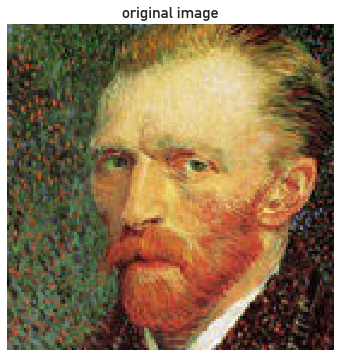

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

import matplotlib.animation as animation
from IPython.display import HTML
import matplotlib
matplotlib.rc('font',family='DIN Alternate')

# select a sample image from the dataset
image_ID = 104
im_b = data[image_ID,:]

# compute the image representation in the basis of principal axes
pca_b = pca.transform(im_b.reshape((1,-1)))

# compute the data mean, for inverse transform
mu = np.mean(data.reshape(N, m*n*p), axis=0).reshape(m, n, p)

# view the original image
fig, ax = plt.subplots(1, 1, figsize=(6,6))
ax.imshow(im_b)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("original image", size=16)
plt.show()

Next we prepare our animations, selecting one representative image to reconstruct. In addition to showcasing the reconstruction of an image with increasing number of principal components, our goal through animation is to offer a cohesive view into the building blocks of the reconstruction. In the top left section, a given principal axis is projected onto the image basis to gain insight into the regions most strongly influenced by a principal component along this axis. Below this, we plot the value of our image's corresponding principal component, and highlight the trend in variance of principal components across our dataset. Finally, we show the cumulative image reconstruction on the right. The projection of principal axes and the reconstruction work in concert to portray how early components focus more attention on coarser features such as a broad background or the subject's silhouette, while latter components refine details distributed across the image.

In [5]:
# animation setup: Refs 4 and 5 cited at the end were used as a general guide.

frames = [1,2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50,60,70,80,90,100]
def get_images(ncomp):
    '''Image reconstruction in original image space using the first ncomp principal components.
       Also returns the representation of the ncomp-1 principal axis in image space.'''
    # reconstructed image
    data = mu + np.dot(pca_b[0,:ncomp],pca.components_[:ncomp,:]).reshape(m, n, p)
    data[data<0]=0
    data[data>1]=1
    # principal axes projected onto the image space
    pax = pca.components_[ncomp-1,:].reshape((m,n,p))
    red_pax = pax[:,:,0]
    green_pax = pax[:,:,1]
    blue_pax = pax[:,:,2]
    
    return data, red_pax, green_pax, blue_pax, pca_b[0, :ncomp]

In [6]:
# initialize figure
fig = plt.figure(figsize=(15,6))
grid = plt.GridSpec(2, 5, wspace=0.3, hspace=0.3)
axp = fig.add_subplot(grid[1,:3])      # principal component plot
ax1 = fig.add_subplot(grid[0,0])       # principal axis projection: red channel
ax2 = fig.add_subplot(grid[0,1])       # principal axis projection: green channel
ax3 = fig.add_subplot(grid[0,2])       # principal axis projection: blue channel
axr = fig.add_subplot(grid[:,3:])     # reconstructed image plot

# principal axis in image space
red_pax, green_pax, blue_pax, y = get_images(frames[-1])[1:]
pr1 = plt.imread("figures/red.png")
pr2 = plt.imread("figures/green.png")
pr3 = plt.imread("figures/blue.png")
for ax, pr in zip([ax1, ax2, ax3],[pr1,pr2,pr3]):
    ax.imshow(pr)
    ax.set_xticks([])
    ax.set_yticks([])
cmap = 'cividis'
red = ax1.imshow(red_pax, cmap=cmap, alpha=0.5)
green = ax2.imshow(green_pax, cmap=cmap, alpha=0.5)
blue = ax3.imshow(blue_pax, cmap=cmap, alpha=0.5)
ax1.set_ylabel("Principal axis\nin image space", size=16)
ax1.set_title("red channel", size=16, color='indianred')
ax2.set_title("green channel", size=16, color='mediumseagreen')
ax3.set_title("blue channel", size=16, color='royalblue')

# principal component plot
nc = frames[-1]
std = np.std(pca.transform(data.reshape((N,-1)))[:,:nc], axis=0)
axp.fill_between(np.arange(nc)+1, -std, std, color='C0', alpha=0.2, label='1 standard deviation')
axp.scatter(np.tile((np.arange(nc)+1).reshape((1,-1)),(N,1)),
            pca.transform(data.reshape((N,-1)))[:,:nc], alpha=0.1, color='C0', s=1)
axp.stem(np.arange(nc)+1, pca.transform(im_b.reshape((1,-1)))[0,:frames[-1]], 
          linefmt='C0-', markerfmt='C0.', basefmt='gold')
axp.legend(fontsize=14)
axp.set_ylim(-35,35)
trace, = axp.plot(1, y[-1], '.', color='khaki', lw=3)
line, = axp.plot([1,1], [0,y[-1]], color='darkslateblue', lw=2)
pt, = axp.plot(1, y[-1], 'o', color='gold', mec="darkslateblue")

axp.set_ylabel("value along\n principal axis", size=16)
axp.set_xlabel("principal component", size=16)

# reconstructed image plot
im = axr.imshow(get_images(1)[0])
axr.set_title("reconstructed image", size=16)
axr.set_xticks([])
axr.set_yticks([])

def animate(i):
    '''Plot updates for animation.'''
    data, red_pax, green_pax, blue_pax, y = get_images(i)
    im.set_data(data) # update reconstructed image
    red.set_data(red_pax)
    green.set_data(green_pax)
    blue.set_data(blue_pax)
    line.set_xdata([i,i])
    line.set_ydata([0,y[-1]])
    pt.set_xdata(i)
    pt.set_ydata(y[-1])
    trace.set_xdata(np.vstack([[j] for j in range(1,i+1)]))
    trace.set_ydata(np.vstack([[j] for j in y]))
    # set a title for the figure as a whole
    if i==1:
        fig.suptitle('1 principal component',size=20)
    else:
        fig.suptitle(str(i)+' principal components',size=20)
    return im, red, green, blue, line, pt, trace,

ani = animation.FuncAnimation(fig, animate, frames=frames, interval=1000, blit=True, repeat_delay=10000)
plt.close(fig)

In [7]:
# Display the animation
HTML(ani.to_html5_video())

In [8]:
# save the animation
ani.save('../artifacts/jovanaandrejevic_artifact.gif', writer='imagemagick', fps=1)

## References

1. "Vincent van Gogh, his Life and Paintings." Vincent van Gogh Paintings, Drawings, Quotes, and Biography. [https://www.vincentvangogh.org/](https://www.vincentvangogh.org/).

2. VanderPlas, Jake. "In Depth: Principal Component Analysis." Python Data Science Handbook: Essential tools for working with data. " O'Reilly Media, Inc.", 2016. [https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html](https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html).

3. “Sklearn.decomposition.PCA.” Scikit-Learn 0.19.2 Documentation, [scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA](scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA).

4. Tiao, Louis. “Embedding Matplotlib Animations in Jupyter Notebooks.” Louis Tiao, 16 Apr. 2016, [louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-notebooks/](louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-notebooks/).

5. Tiao, Louis. “Save Matplotlib Animations as GIFs.” Louis Tiao, 4 Aug. 2016, [http://louistiao.me/posts/notebooks/save-matplotlib-animations-as-gifs/](http://louistiao.me/posts/notebooks/save-matplotlib-animations-as-gifs/).